In [1]:
import numpy as np
import sncosmo
from astropy.table import Table
from matplotlib import pyplot as plt

import sys; sys.path.insert(0, '../')
from data_access import sdss


Registering band "doi_2010_u1" with sncosmo.
Registering band "doi_2010_u1" with sncosmo.
Registering band "doi_2010_u2" with sncosmo.
Registering band "doi_2010_u2" with sncosmo.
Registering band "doi_2010_u3" with sncosmo.
Registering band "doi_2010_u3" with sncosmo.
Registering band "doi_2010_u4" with sncosmo.
Registering band "doi_2010_u4" with sncosmo.
Registering band "doi_2010_u5" with sncosmo.
Registering band "doi_2010_u5" with sncosmo.
Registering band "doi_2010_u6" with sncosmo.
Registering band "doi_2010_u6" with sncosmo.
Registering band "doi_2010_g1" with sncosmo.
Registering band "doi_2010_g1" with sncosmo.
Registering band "doi_2010_g2" with sncosmo.
Registering band "doi_2010_g2" with sncosmo.
Registering band "doi_2010_g3" with sncosmo.
Registering band "doi_2010_g3" with sncosmo.
Registering band "doi_2010_g4" with sncosmo.
Registering band "doi_2010_g4" with sncosmo.
Registering band "doi_2010_g5" with sncosmo.
Registering band "doi_2010_g5" with sncosmo.
Registerin

## Get SDSS published table of spectroscopically confirmed SNIa

In [2]:
spec_confirmed_sn = sdss.master_table[sdss.master_table['Classification'] == 'zSNIa']
spec_confirmed_sn.show_in_notebook(display_length=10)


idx,CID,RA,DEC,Nsearchepoch,IAUName,Classification,Peakrmag,MJDatPeakrmag,NepochSNR5,nSNspec,nGALspec,zspecHelio,zspecerrHelio,zCMB,zerrCMB,x0SALT2zspec,x0errSALT2zspec,x1SALT2zspec,x1errSALT2zspec,cSALT2zspec,cerrSALT2zspec,PeakMJDSALT2zspec,PeakMJDderrSALT2zspec,muSALT2zspec,muerrSALT2zspec,fitprobSALT2zspec,chi2SALT2zspec,ndofSALT2zspec,deltaMLCS2k2zspec,deltaerrMLCS2k2zspec,avMLCS2k2zspec,averrMLCS2k2zspec,PeakMJDMLCS2k2zspec,PeakMJDerrMLCS2k2zspec,muMLCS2k2zspec,muerrMLCS2k2zspec,fitprobMLCS2k2zspec,chi2MLCS2k2zspec,ndofMLCS2k2zspec,PIaPSNIDzspec,logprobIaPSNIDzspec,lcqualityIaPSNIDzspec,PIbcPSNIDzspec,logprobIbcPSNIDzspec,lcqualityIbcPSNIDzspec,PIIPSNIDzspec,logprobIIPSNIDzspec,lcqualityIIPSNIDzspec,NnnPSNIDzspec,PnnIaPSNIDzspec,PnnIbcPSNIDzspec,PnnIIPSNIDzspec,zPSNIDzspec,zerrPSNIDzspec,dm15PSNIDzspec,dm15errPSNIDzspec,avPSNIDzspec,averrPSNIDzspec,PeakMJDPSNIDzspec,PeakMJDerrPSNIDzspec,SNIbctypePSNIDzspec,SNIItypePSNIDzspec,x0SALT2flat,x0errSALT2flat,x1SALT2flat,x1errSALT2flat,cSALT2flat,cerrSALT2flat,PeakMJDSALT2flat,PeakMJDerrSALT2flat,zphotSALT2flat,zphoterrSALT2flat,fitprobSALT2flat,chi2SALT2flat,ndofSALT2flat,PIaPSNIDflat,logprobIaPSNIDflat,lcqualityIaPSNIDflat,PIbcPSNIDflat,logprobIbcPSNIDflat,lcqualityIbcPSNIDflat,PIIPSNIDflat,logprobIIPSNIDflat,lcqualityIIPSNIDflat,NnnPSNIDflat,PnnIaPSNIDflat,PnnIbcPSNIDflat,PnnIIPSNIDflat,zPSNIDflat,zerrPSNIDflat,dm15PSNIDflat,dm15errPSNIDflat,avPSNIDflat,averrPSNIDflat,PeakMJDPSNIDflat,PeakMJDerrPSNIDflat,SNIbctypePSNIDflat,SNIItypePSNIDflat,objIDHost,RAhost,DEChost,separationhost,DLRhost,zphothost,zphoterrhost,zphotRFhost,zphotRFerrhost,dereduhost,erruhost,deredghost,errghost,deredrhost,errrhost,deredihost,errihost,deredzhost,errzhost,logMassFSPS,logMassloFSPS,logMasshiFSPS,logSSFRFSPS,logSSFRloFSPS,logSSFRhiFSPS,ageFSPS,ageloFSPS,agehiFSPS,minredchi2FSPS,logMassPEGASE,logMassloPEGASE,logMasshiPEGASE,logSFRPEGASE,logSFRloPEGASE,logSFRhiPEGASE,agePEGASE,minchi2PEGASE,Notes
0,703,336.217897,0.650723,5,--,zSNIa,21.3,53623.2,6,0,1,0.298042,2e-05,0.296481,2e-05,5.43e-05,3.47e-06,0.73,0.63,-0.01,0.05,53626.5,0.65,40.8,0.24,0.966,40.8,59,-0.27,0.13,0.34,0.14,53625.5,0.78,40.86,0.17,0.998,44.4,74,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,5.29e-05,3.8e-06,0.77,0.69,-0.05,0.08,53626.6,0.81,0.3177,0.0418,0.953,27.9,42,1.0,0.0,63,0.0,-0.0061,63,0.0,-0.161,63,1278,0.985,0.009,0.005,0.313,0.0308,0.92,0.11,0.02,0.21,53625.48,0.89,306,301,1237663544222483004,336.217957,0.650779,0.21,0.25,0.392,0.0682,0.3174,0.0959,22.305,0.313,21.829,0.093,20.89,0.064,20.622,0.078,20.453,0.217,9.96,9.83,10.08,-10.17,-10.37,-10.0,3.74,2.39,5.58,0.16,9.86,9.57,10.16,0.41,-0.14,0.61,1.8,0.68,--
1,735,7.963306,0.801202,5,--,zSNIa,21.0,53616.3,4,0,0,0.190858,4.5e-05,0.189482,4.5e-05,8.82e-05,1.23e-05,-2.66,0.58,0.01,0.09,53610.7,1.79,39.61,0.27,0.955,20.6,33,1.4,0.13,-0.66,0.19,53615.1,1.19,39.9,0.17,0.917,46.4,61,1.0,-0.0039,51,0.0,-0.369,59,0.0,-8.88,3,--,--,--,--,0.2403,0.0829,1.53,0.15,-0.04,0.6,53610.85,2.18,4,4,--,--,--,--,--,--,--,--,--,--,--,--,--,0.961,-0.0,55,0.039,-0.0074,63,0.0,-3.56,55,151,0.927,0.04,0.033,0.2697,0.0721,1.55,0.14,-0.07,0.48,53612.43,2.49,307,301,1237663204917641393,7.963525,0.80104,1.01,0.98,0.1989,0.0099,0.2081,0.0351,22.605,0.469,20.398,0.033,19.082,0.016,18.579,0.017,18.198,0.037,10.83,10.73,10.92,-15.92,-44.04,-12.45,8.35,5.46,10.35,0.09,10.68,10.62,10.72,-99.0,-99.0,-99.0,8.0,1.77,--
2,779,26.673767,-1.020637,7,--,zSNIa,20.8,53626.4,8,0,1,0.238121,2.1e-05,0.236938,2.1e-05,7.72e-05,3.68e-06,0.46,0.38,0.02,0.04,53626.9,0.41,40.3,0.21,0.991,42.8,67,-0.19,0.11,0.36,0.11,53626.0,0.63,40.39,0.13,0.99,55.2,82,1.0,0.0,63,0.0,-1.65,63,0.0,-13.0,63,--,--,--,--,0.2424,0.0286,0.96,0.08,0.31,0.22,53626.05,0.68,3,1,7.6e-05,3.74e-06,0.52,0.4,0.02,0.06,53627.1,0.53,0.2472,0.0289,0.92,35.8,49,1.0,0.0,63,0.0,-1.43,63,0.0,-1.91,63,1766,0.981,0.003,0.016,0.25,0.0288,0.95,0.08,0.34,0.21,53626.14,0.71,306,301,1237657069548208337,26.673767,-1.020636,0.23,0.2,0.2132,0.0403,0.

## Pick an arbitrary target and look at the light curve

Published Values for CID 911:
('x0: ', 4.97e-05)
('x1: ', -0.39)
('c: ', 0.23)
('chisq: ', 45.1)
('ndof: ', 54)
('chisq_norm: ', 0.8351851851851853)


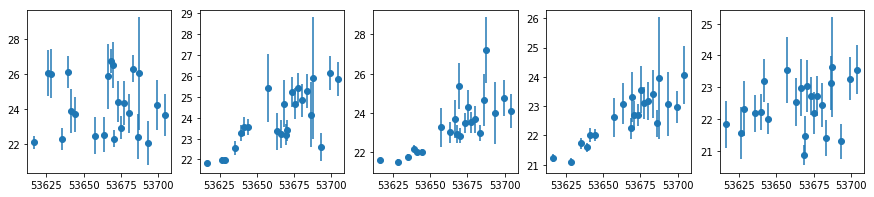

idx,FLAG,MJD,FILT,MAG,MERR,MSKYERR,MGALERR,FLUX,FLUXERR,SKYERR,GALERR,NPRE,TELE,RUN,STRIP,IDCCD
0,0,53616.42027,1,21.816,0.103,0.047,0.105,6.677,0.6313,0.2908,0.6493,18,sdss,5566,82N,3
1,32,53616.416953,2,21.576,0.113,0.03,0.067,8.445,0.8822,0.2311,0.5266,24,sdss,5566,82N,3
2,32,53616.417782,3,21.22,0.135,0.072,0.077,11.58,1.44,0.7693,0.8249,24,sdss,5566,82N,3
3,32,53616.419441,4,21.83,0.739,0.667,0.528,5.619,5.122,4.751,3.758,23,sdss,5566,82N,3
4,8,53616.418611,0,22.064,0.377,0.223,0.635,5.726,1.909,1.173,3.335,13,sdss,5566,82N,3
5,32,53626.397193,1,21.966,0.133,0.119,0.17,5.812,0.7112,0.6411,0.9106,18,sdss,5603,82N,3
6,164,53626.396364,4,21.555,0.811,0.27,0.682,7.775,6.565,2.344,5.914,23,sdss,5603,82N,3
7,130,53626.395535,0,26.068,1.298,0.41,3.211,-1.769,2.138,0.766,5.991,13,sdss,5603,82N,3
8,1,53628.382307,1,21.954,0.183,0.077,0.089,5.877,0.9865,0.4205,0.4839,18,sdss,5610,82N,3
9,160,53628.37899,2,21.477,0.15,0.045,0.072,9.255,1.279,0.3889,0.6201,24,sdss,5610,82N,3


In [8]:
test_id = 911

# Get fit published values
published_values = sdss.master_table[sdss.master_table['CID'] == test_id]
x0 = published_values['x0SALT2zspec'][0]
x1 = published_values['x1SALT2zspec'][0]
c = published_values['cSALT2zspec'][0]
chisq_norm = published_values['chi2SALT2zspec'][0] / published_values['ndofSALT2zspec'][0]
peak_mjd = published_values['MJDatPeakrmag'][0]

print('Published Values for CID {}:'.format(test_id))
print('x0: ', x0)
print('x1: ', x1)
print('c: ', c)
print('chisq: ', published_values['chi2SALT2zspec'][0])
print('ndof: ', published_values['ndofSALT2zspec'][0])
print('chisq_norm: ', chisq_norm)

# Get sdss photometry data and apply cuts described in Sako et al,
phot_data = sdss.get_data_for_id(test_id)
phot_data = phot_data[phot_data['FLAG'] < 1024]
#phot_data = phot_data[phot_data['MJD'] < peak_mjd + 45]
#phot_data = phot_data[phot_data['MJD'] > peak_mjd - 15]

fig, axes = plt.subplots(1, 5, figsize=(15, 3))
for i in range(5):
    band_data = phot_data[phot_data['FILT'] == i]
    axes[i].scatter(band_data['MJD'], band_data['MAG'])
    axes[i].errorbar(band_data['MJD'], band_data['MAG'], yerr=band_data['MERR'], linestyle='')

plt.show()

phot_data.show_in_notebook(display_length=10)


## Get outlier data points

In [ ]:
f_path = '/Users/daniel/Github/SDSS-Classification/data_access/sdss/data/SDSS_dataRelease-snana/SDSS_allCandidates+BOSS/SDSS_allCandidates+BOSS.IGNORE'

outliers = dict()
with open(f_path) as ofile:
    for line in ofile.readlines():
        if line.startswith('IGNORE:'):
            line_list = line.split()
            cid, mjd, band = line_list[1], line_list[2], line_list[3]
            if cid not in outliers:
                outliers[cid] = dict(u=[], g=[], r=[], i=[], z=[])
            
            outliers[cid][band].append(mjd)

## Create an SNCosmo input table

In [9]:
@np.vectorize
def sdss_mag_to_ab_flux(mag, band):
    """For a given sdss magnitude return the AB flux

    Args:
        mag (float): An SDSS asinh magnitude
        band  (str): The band of the magnitude doi_2010_<ugriz><123456>
        
    Return:
        The equivalent AB magnitude
    """

    if band[-2] == 'u':
        offset = -0.679

    elif band[-2] == 'g':
        offset = 0.0203

    elif band[-2] == 'r':
        offset = 0.0049

    elif band[-2] == 'i':
        offset = 0.0178

    elif band[-2] == 'z':
        offset = 0.0102

    else:
        ValueError('Unknown band {}'.format(band))

    return 3631 * 10 ** ((mag + offset) / -2.5)


def calc_err(sigma_sdss_mag, flux_ab):
    """Calculate the error of the AB magnitude equivilent for an SDSS asinh mag 
    
    Args:
        sigma_sdss_mag (float): Error in the SDSS magnitude
        flux_ab        (float): AB flux of the measurement
        
    Returns:
        The error in the equivalent AB flux
    """

    return sigma_sdss_mag * flux_ab * np.log(10) / 2.5


@np.vectorize
def band_name(filt, idccd):
    """Return the sncosmo band name given filter and CCD id
    
    Args:
        filt  (str): Filter name <ugriz>
        idccd (int): Column number 1 through 6
    
    Args:
        The name of the filter registered with sncosmo
    """

    return 'doi_2010_{}{}'.format('ugriz'[filt], idccd)

In [10]:
input_table = Table()
input_table.meta = phot_data.meta
input_table['time'] = phot_data['MJD']
input_table['band'] = band_name(phot_data['FILT'], phot_data['IDCCD'])
input_table['zp'] = np.full(len(phot_data), 2.5 * np.log10(3631))
input_table['flux'] = sdss_mag_to_ab_flux(phot_data['MAG'], input_table['band'])
input_table['fluxerr'] = calc_err(phot_data['MERR'], input_table['flux'])
input_table['zpsys'] = np.full(len(phot_data), 'ab')

input_table.show_in_notebook(display_length=10)


idx,time,band,zp,flux,fluxerr,zpsys
0,53616.42027,doi_2010_g3,8.90006562228223,6.691234477621489e-06,6.347740345902406e-07,ab
1,53616.416953,doi_2010_r3,8.90006562228223,8.465765782221893e-06,8.81090203309729e-07,ab
2,53616.417782,doi_2010_i3,8.90006562228223,1.1611979191554422e-05,1.4438287900780343e-06,ab
3,53616.419441,doi_2010_z3,8.90006562228223,6.6672424601259756e-06,4.538019600378629e-06,ab
4,53616.418611,doi_2010_u3,8.90006562228223,1.0139726687532767e-05,3.520815594476225e-06,ab
5,53626.397193,doi_2010_g3,8.90006562228223,5.827821601867105e-06,7.138937337186751e-07,ab
6,53626.396364,doi_2010_z3,8.90006562228223,8.589072110286704e-06,6.415681314591772e-06,ab
7,53626.395535,doi_2010_u3,8.90006562228223,2.537618015765124e-07,3.03372787057138e-07,ab
8,53628.382307,doi_2010_g3,8.90006562228223,5.892590332474857e-06,9.93191556215188e-07,ab
9,53628.37899,doi_2010_r3,8.90006562228223,9.273982005988945e-06,1.2812479631811098e-06,ab


## Run fit



Fitting for all terms except z:


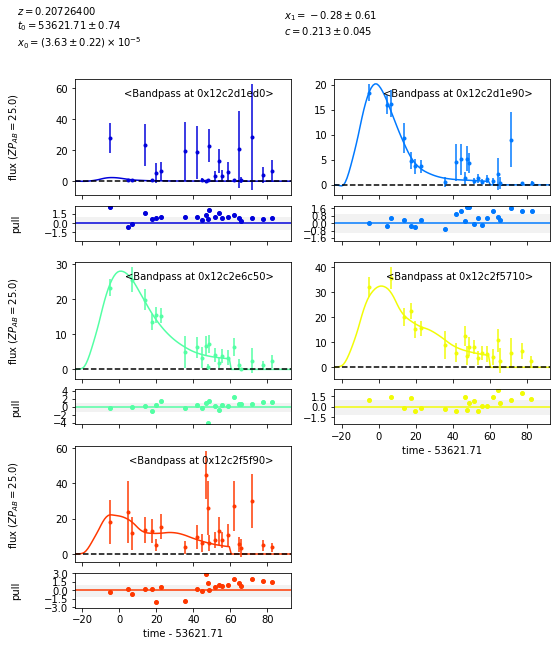

       errors: OrderedDict([('t0', 0.7408590750674193), ('x0', 2.2133708378525038e-06), ('x1', 0.6100300561401867), ('c', 0.04500015603153835)])
   parameters: array([ 2.07264000e-01,  5.36217070e+04,  3.62741115e-05, -2.82656209e-01,
        2.13303220e-01])
      success: True
    chi2_norm: 1.3458525060860818
    data_mask: array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,

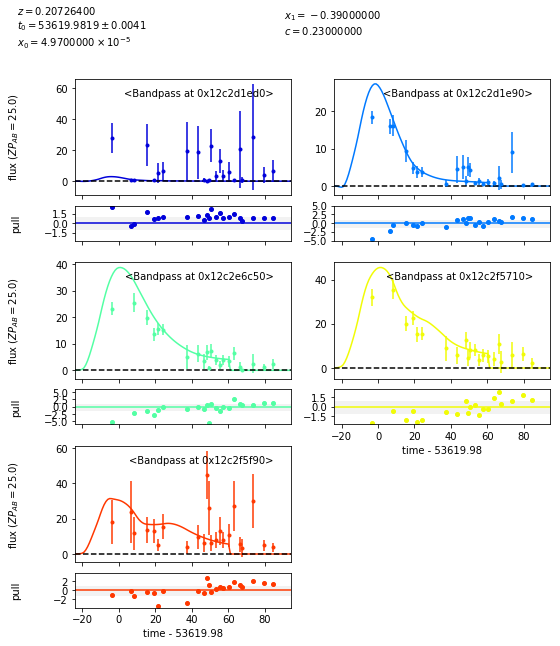

       errors: OrderedDict([('t0', 0.004073898235219531)])
   parameters: array([ 2.07264000e-01,  5.36199819e+04,  4.97000000e-05, -3.90000000e-01,
        2.30000000e-01])
      success: True
    chi2_norm: 2.333551876798428
    data_mask: array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  T

In [11]:
print('\n\nFitting for all terms except z:')
source = sncosmo.get_source('salt2', version='2.0')
model = sncosmo.Model(source=source)
model.set(z=input_table.meta['redshift'])

result, fitted_model = sncosmo.fit_lc(input_table, model, ['t0', 'x0', 'x1', 'c'], bounds=None)
result['chi2_norm'] = (result.chisq / result.ndof)
sncosmo.plot_lc(input_table, model=fitted_model, errors=result.errors)
plt.show()
print(result)

print('\n\nFitting with fixed, published values:')
model.set(z=input_table.meta['redshift'], x0=x0, x1=x1, c=c)
result, fitted_model = sncosmo.fit_lc(input_table, model, ['t0'], bounds=None)
result['chi2_norm'] = (result.chisq / result.ndof)
sncosmo.plot_lc(input_table, model=fitted_model, errors=result.errors)
plt.show()
print(result)
print('\n\n\n')
